# Trading Signal

In [1]:
import datastore.datastore as datastore
import datetime
import time

import ta

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Retrieve BTC/USD data

In [2]:
# Keep `realtime_prices` on so there's no missing data
d = datastore.DataStore(None, realtime_prices=True)

# The cache needs a bit of time to warm up
time.sleep(60 - datetime.datetime.now().second)

In [3]:
# Every time this function is called, it returns the current time - `minutes` as a string
get_start_time = lambda minutes: (datetime.datetime.now() - datetime.timedelta(minutes=minutes)).strftime("%Y-%m-%d %H:%M:%S")

In [4]:
# Ranges are inclusive, so if you want exactly 200 data points use 199 minutes
data_real_min = d.btcstock.get_by_range(get_start_time(1439), delay=0, verbose=False)
data_real_min

,timestamp,high,volume,low,close,open
0,2020-12-08 11:31:00,18865.16,1.298447,18849.46,18858.54,18860.59
1,2020-12-08 11:32:00,18862.69,0.986116,18843.60,18849.00,18856.24
2,2020-12-08 11:33:00,18856.90,0.375913,18848.27,18852.26,18848.27
3,2020-12-08 11:34:00,18866.31,0.903735,18852.25,18864.86,18852.25
4,2020-12-08 11:35:00,18859.78,2.062747,18850.00,18850.00,18857.25
...,...,...,...,...,...,...
1435,2020-12-09 11:26:00,18249.20,4.379937,18235.96,18244.09,18249.20
1436,2020-12-09 11:27:00,18250.00,0.546329,18236.29,18243.70,18236.29
1437,2020-12-09 11:28:00,18250.00,0.528203,18237.43,18237.43,18243.70
1438,2020-12-09 11:29:00,18249.99,0.376504,18239.08,18242.10,18239.08


## Technical Analysis - Exponential Moving Average (EMA) & Ichimoku Cloud

In [5]:
def countX(lst, x): 
    """
    Counts the number of times 'x' appeared in the list lst
    """
    return lst.count(x)

In [6]:
def fill_trends(df):
    """
    Computes the various indicators using the closing price and updates the dataframe 
    with new columns of these indicators
    
    Returns:
    --------
    Dataframe with indicators added as new columns
    """
    # exponential moving averages of various timeperiods
    df['ema_5'] = ta.trend.EMAIndicator(close = df['close'], n = 5).ema_indicator()
    df['ema_13'] = ta.trend.EMAIndicator(close = df['close'], n = 13).ema_indicator()
    df['ema_21'] = ta.trend.EMAIndicator(close = df['close'], n = 21).ema_indicator()
    df['ema_34'] = ta.trend.EMAIndicator(close = df['close'], n = 34).ema_indicator()
    df['ema_55'] = ta.trend.EMAIndicator(close = df['close'], n = 55).ema_indicator()
    df['ema_100'] = ta.trend.EMAIndicator(close = df['close'], n = 100).ema_indicator()
    df['ema_200'] = ta.trend.EMAIndicator(close = df['close'], n = 200).ema_indicator()

    # ichimoku cloud
    ichi_ind = ta.trend.IchimokuIndicator(high = df['high'], low = df['low'],n1=9, n2=26, n3=52)
    df['ichi_lead_a'] = ichi_ind.ichimoku_a()
    df['ichi_lead_b'] = ichi_ind.ichimoku_b()
    df['ichi_base'] = ichi_ind.ichimoku_base_line()
    df['ichi_conver'] = ichi_ind.ichimoku_conversion_line()
    df['ichi_lag'] = df['close'].shift(-26)
    
    return df.fillna(0.0)

## Generate Trading Signals using EMA Crossover Strategy

In [7]:
def ma_crossover(df, close, slow, fast):
    """
    Computes the position to take at each point in time 
    based on the moving average crossover strategy for various range of time periods
    
    If the slower moving average rises above the faster moving average, signal is 1.
    Else is 0
    
    The position take into consideration the signal given.
    Position: Buy if 1 or Sell if -1
    
    Returns dataframe df with signal and position
    """
    df['close'] = close
    df['slow'] = slow
    df['fast'] = fast
    df['signal'] = 0.0
    df['signal'] = np.where(slow > fast, 1.0, 0.0)
    # position is the difference of the signals. Buy is 1 and Sell is -1.
    df['position'] = df['signal'].diff()
    return df

In [8]:
def plot_strategy(df, slow_label, fast_label):
    """
    Plots the moving average crossover strategy with buy and sell signals
    """
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    # plot close price, short-term and long-term moving averages 
    df['close'].plot(color = 'k', lw = 1, label = 'Close Price')  
    df['slow'].plot(color = 'b', lw = 1, label = slow_label) 
    df['fast'].plot(color = 'g', lw = 1, label = fast_label) 

    # plot 'buy' signals
    plt.plot(df[df['position'] == 1].index, 
             df['slow'][df['position'] == 1], 
             '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df[df['position'] == -1].index, 
             df['fast'][df['position'] == -1], 
             'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.ylabel('BTC/USD', fontsize = 15 )
    plt.xlabel('Time', fontsize = 15 )
    plt.title('BTC/USD - EMA Crossover chart', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
def gauge(avg_pos):
    """
    Transforms the average position (int) into the respective action (string) 
    of strong buy, buy, neutral, sell or strong sell
    """
    if 0.6 <= avg_pos <= 1.0:
        return 'Strong Buy'
    elif 0.2 <= avg_pos <0.6:
        return 'Buy'
    elif -0.2 <=avg_pos< 0.2:
        return 'Neutral'
    elif -0.6 <= avg_pos < -0.2:
        return 'Sell'
    elif -1.0 <= avg_pos < -0.6:
        return 'Strong Sell'

In [10]:
def plot_crossover(data):
    """
    Plots all 10 exponential moving average strategies with buy and sell signals 
    """
    ema_5_200 = data['timestamp'].to_frame()
    ma_crossover(ema_5_200, data['close'], data['ema_5'], data['ema_200'])
    plot_strategy(ema_5_200, 'EMA 5', 'EMA 200')


    ema_13_100 = data['timestamp'].to_frame()
    ma_crossover(ema_13_100, data['close'], data['ema_13'], data['ema_100'])
    plot_strategy(ema_13_100, 'EMA 13', 'EMA 100')

    ema_13_200 = data['timestamp'].to_frame()
    ma_crossover(ema_13_200, data['close'], data['ema_13'], data['ema_200'])
    plot_strategy(ema_13_200, 'EMA 13', 'EMA 200')


    ema_21_100 = data['timestamp'].to_frame()
    ma_crossover(ema_21_100, data['close'], data['ema_21'], data['ema_100'])
    plot_strategy(ema_21_100, 'EMA 21', 'EMA 100')

    ema_21_200 = data['timestamp'].to_frame()
    ma_crossover(ema_21_200, data['close'], data['ema_21'], data['ema_200'])
    plot_strategy(ema_21_200, 'EMA 21', 'EMA 200')

    ema_34_55 = data['timestamp'].to_frame()
    ma_crossover(ema_34_55, data['close'], data['ema_34'], data['ema_55'])
    plot_strategy(ema_34_55, 'EMA 34', 'EMA 55')

    ema_34_100 = data['timestamp'].to_frame()
    ma_crossover(ema_34_100, data['close'], data['ema_34'], data['ema_100'])
    plot_strategy(ema_34_100, 'EMA 34', 'EMA 100')

    ema_34_200 = data['timestamp'].to_frame()
    ma_crossover(ema_34_200, data['close'], data['ema_34'], data['ema_200'])
    plot_strategy(ema_34_200, 'EMA 34', 'EMA 200')

    ema_55_100 = data['timestamp'].to_frame()
    ma_crossover(ema_55_100, data['close'], data['ema_55'], data['ema_100'])
    plot_strategy(ema_55_100, 'EMA 55', 'EMA 100')

    ema_55_200 = data['timestamp'].to_frame()
    ma_crossover(ema_55_200, data['close'], data['ema_55'], data['ema_200'])
    plot_strategy(ema_55_200, 'EMA 55', 'EMA 200')

In [11]:
def ema_strategy(data):
    """
    Computes the action given by 10 different exponential moving average-based trading strategies
    Returns:
        a list of the actions each ema strategy suggests
    """
    ema_5_200 = data['timestamp'].to_frame()
    ma_crossover(ema_5_200, data['close'], data['ema_5'], data['ema_200'])

    ema_13_100 = data['timestamp'].to_frame()
    ma_crossover(ema_13_100, data['close'], data['ema_13'], data['ema_100'])

    ema_13_200 = data['timestamp'].to_frame()
    ma_crossover(ema_13_200, data['close'], data['ema_13'], data['ema_200'])

    ema_21_100 = data['timestamp'].to_frame()
    ma_crossover(ema_21_100, data['close'], data['ema_21'], data['ema_100'])

    ema_21_200 = data['timestamp'].to_frame()
    ma_crossover(ema_21_200, data['close'], data['ema_21'], data['ema_200'])

    ema_34_55 = data['timestamp'].to_frame()
    ma_crossover(ema_34_55, data['close'], data['ema_34'], data['ema_55'])

    ema_34_100 = data['timestamp'].to_frame()
    ma_crossover(ema_34_100, data['close'], data['ema_34'], data['ema_100'])

    ema_34_200 = data['timestamp'].to_frame()
    ma_crossover(ema_34_200, data['close'], data['ema_34'], data['ema_200'])

    ema_55_100 = data['timestamp'].to_frame()
    ma_crossover(ema_55_100, data['close'], data['ema_55'], data['ema_100'])

    ema_55_200 = data['timestamp'].to_frame()
    ma_crossover(ema_55_200, data['close'], data['ema_55'], data['ema_200'])
    
    ema_positions = [(ema_5_200.iloc[-1,-1]),  
                     (ema_13_100.iloc[-1,-1]), (ema_13_200.iloc[-1,-1]),  
                     (ema_21_100.iloc[-1,-1]), (ema_21_200.iloc[-1,-1]),  
                     (ema_34_55.iloc[-1,-1]), (ema_34_100.iloc[-1,-1]), (ema_34_200.iloc[-1,-1]),  
                     (ema_55_100.iloc[-1,-1]), (ema_55_200.iloc[-1,-1])]
    
    return ema_positions

## Generate Trading Signals using Ichimoku Cloud

In [12]:
def ichimoku_strategy(data):
    """
    Computes the action given by two Ichimoku Cloud-based trading strategies
    Returns:
        a list of the actions each of the Ichimoku strategies suggests 
    """
    df = data['timestamp'].to_frame()
    df['close'] = data['close']
    df['conver_base_signal'] = 0.0
    df['price_base_signal'] = 0.0
    for i in range(len(df)):
        # Conversion-Base Signal
        # If the price is above the green cloud (leading span a > leading span b) and conversion span > base span,
        # signal = 1, bullish
        if ((data['close'][i] > data['ichi_lead_a'][i])
            and (data['ichi_lead_a'][i] > data['ichi_lead_b'][i])
            and (data['ichi_conver'][i] > data['ichi_base'][i])):
                df.iloc[i, -2] = 1.0
        # If the price is below the red cloud (leading span a < leading span b) and conversion span < base span,
        # signal = -1, bearish
        elif ((data['close'][i] < data['ichi_lead_a'][i])
            and (data['ichi_lead_a'][i] < data['ichi_lead_b'][i])
            and (data['ichi_conver'][i] < data['ichi_base'][i])):
                df.iloc[i, -2] = -1.0
        
        # Price-Base Signal
        # If the price is above the green cloud (leading span a > leading span b) and price > base span,
        # signal = 1, bullish
        elif ((data['close'][i] > data['ichi_lead_a'][i])
            and (data['ichi_lead_a'][i] > data['ichi_lead_b'][i])
            and (data['close'][i] > data['ichi_base'][i])):
                df.iloc[i, -1] = 1.0
        # If the price is below the red cloud (leading span a < leading span b) and price < base span,
        # signal = -1, bearish
        elif ((data['close'][i] < data['ichi_lead_a'][i])
            and (data['ichi_lead_a'][i] < data['ichi_lead_b'][i])
            and (data['close'][i] < data['ichi_base'][i])):
                df.iloc[i, -1] = -1.0
    return df.iloc[-1,-2:]

# Gauge the Trading Signal based on EMA & Ichimoku Cloud Strategies

In [13]:
# Must run this cell to call the fill_trends function 
# to compute the indicators needed and add them to the 'data_real_min' dataframe
# it updates the dataframe inplace
fill_trends(data_real_min).head()

,timestamp,high,volume,low,close,open,ema_5,ema_13,ema_21,ema_34,ema_55,ema_100,ema_200,ichi_lead_a,ichi_lead_b,ichi_base,ichi_conver,ichi_lag
0,2020-12-08 11:31:00,18865.16,1.298447,18849.46,18858.54,18860.59,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18857.310,0.0,0.0,18794.38
1,2020-12-08 11:32:00,18862.69,0.986116,18843.60,18849.00,18856.24,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18854.380,0.0,0.0,18797.73
2,2020-12-08 11:33:00,18856.90,0.375913,18848.27,18852.26,18848.27,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18854.380,0.0,0.0,18789.47
3,2020-12-08 11:34:00,18866.31,0.903735,18852.25,18864.86,18852.25,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18854.955,0.0,0.0,18778.43
4,2020-12-08 11:35:00,18859.78,2.062747,18850.00,18850.00,18857.25,18855.225185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18854.955,0.0,0.0,18774.73


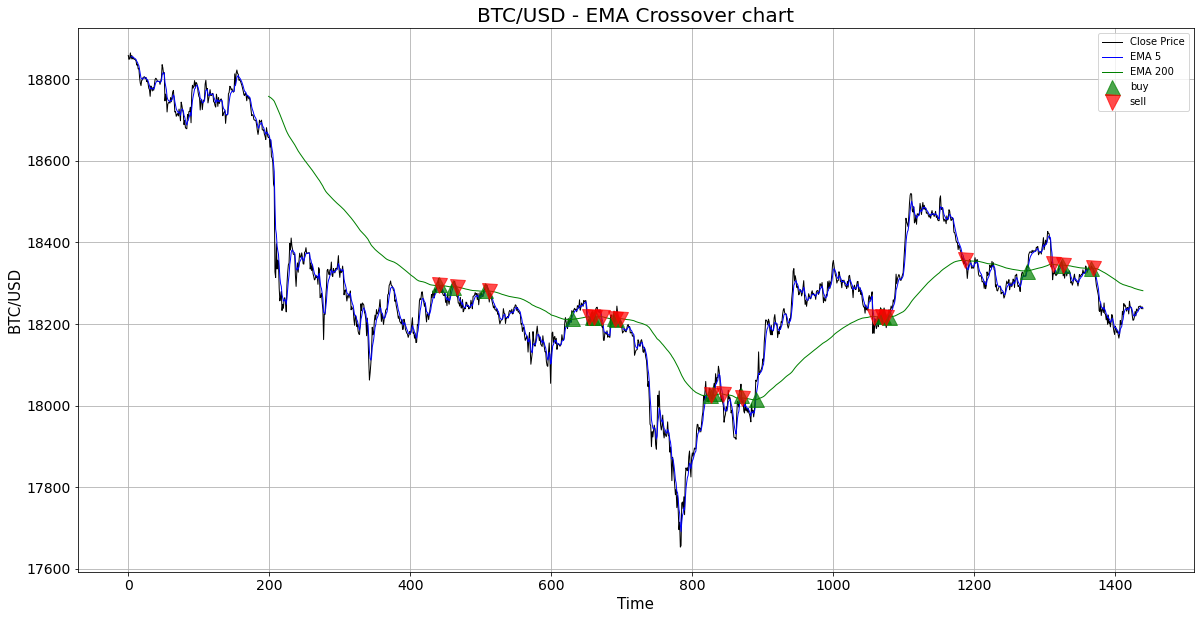

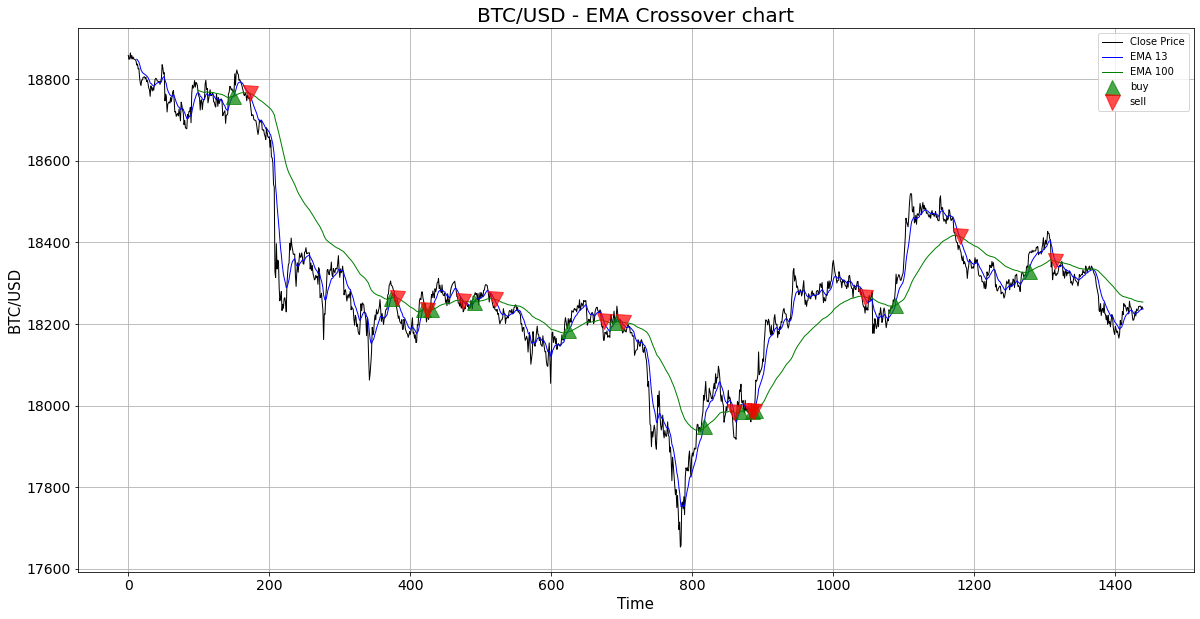

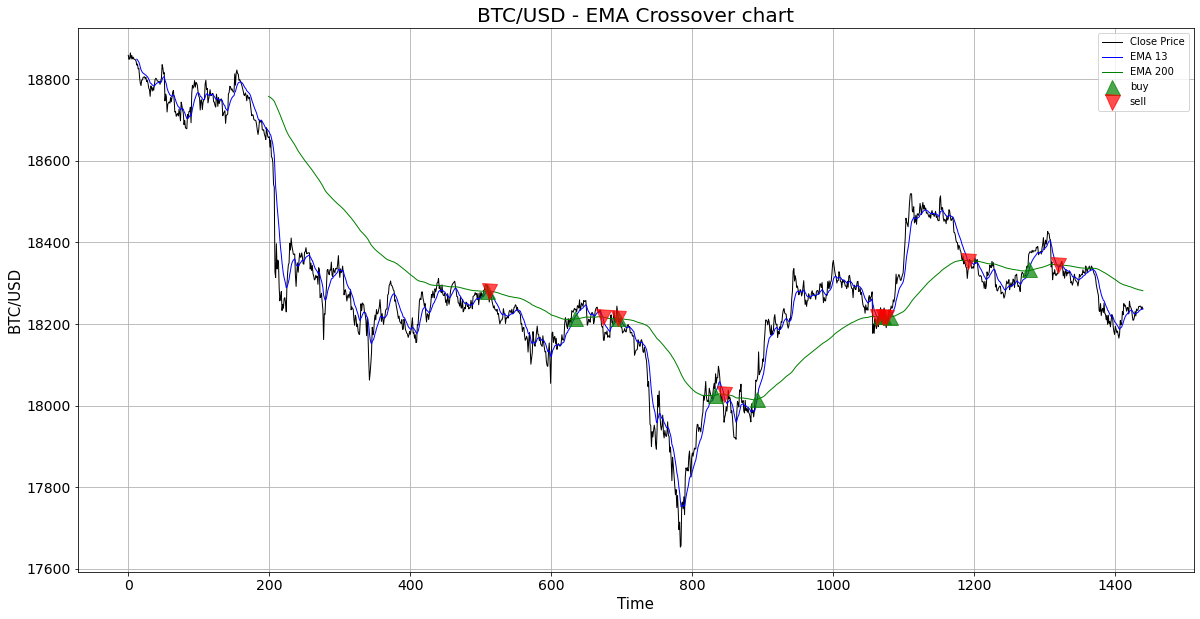

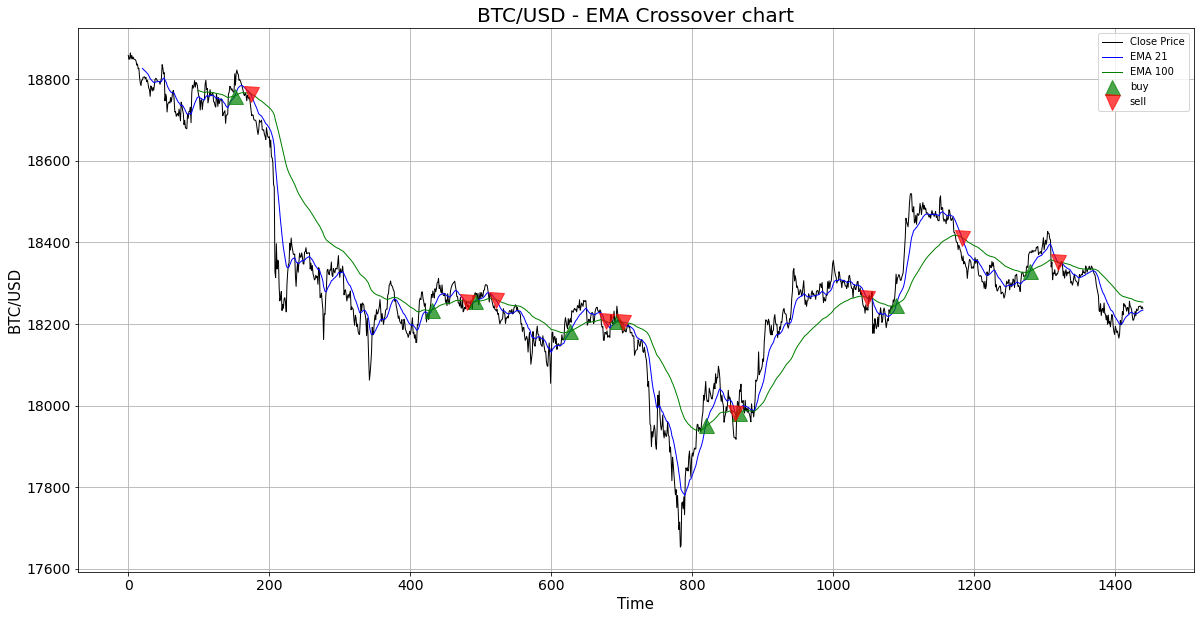

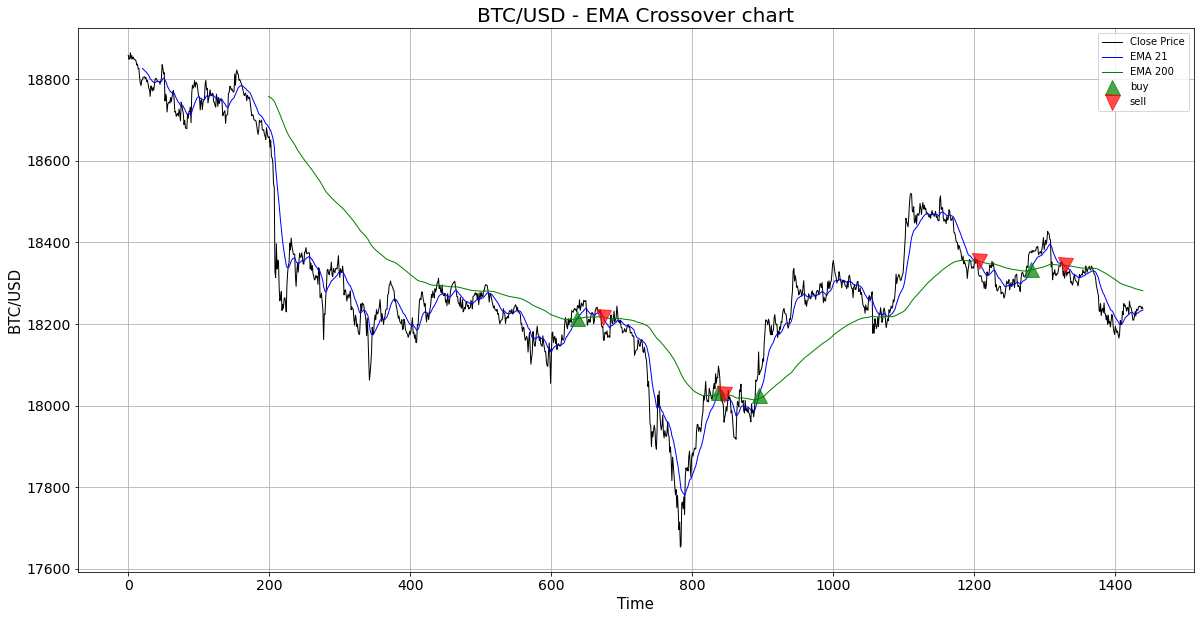

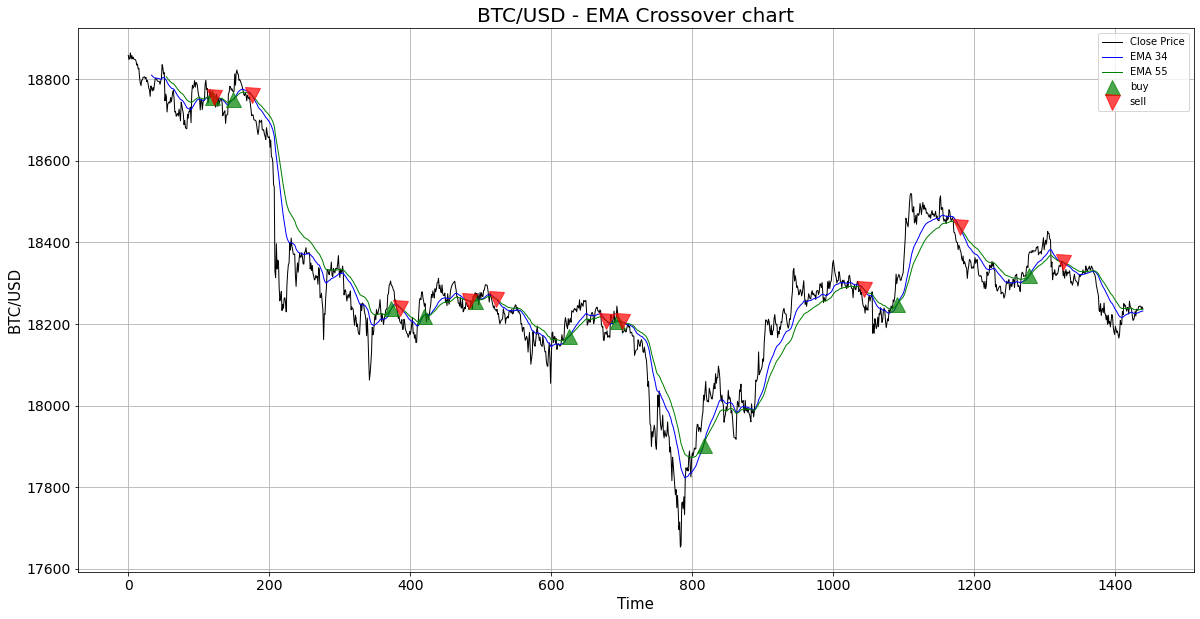

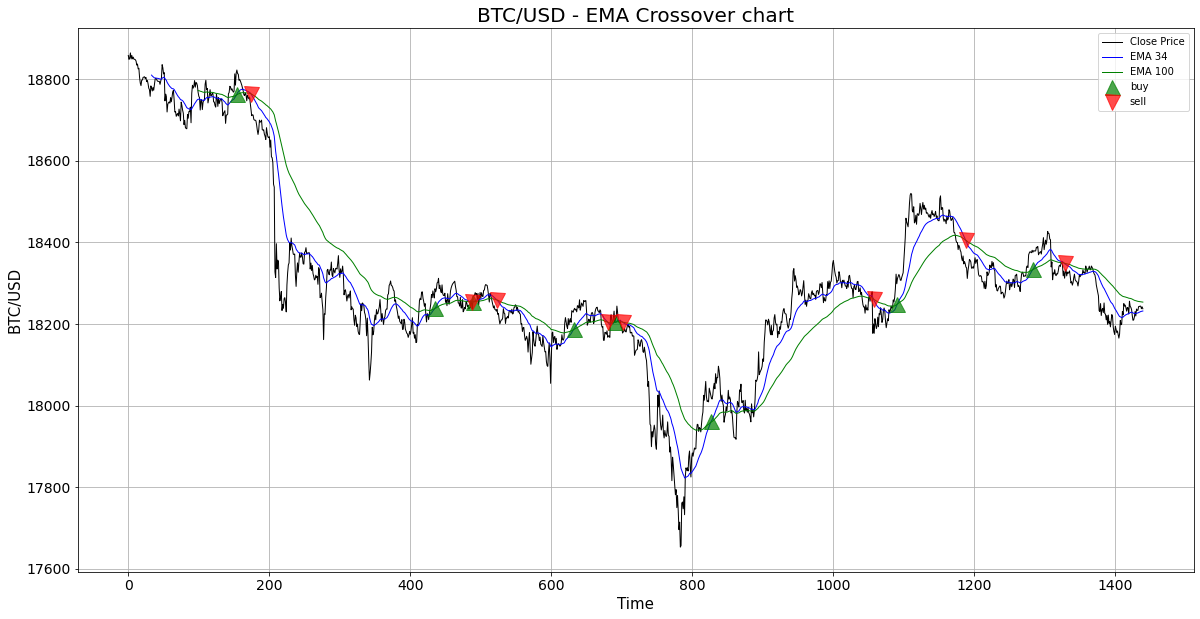

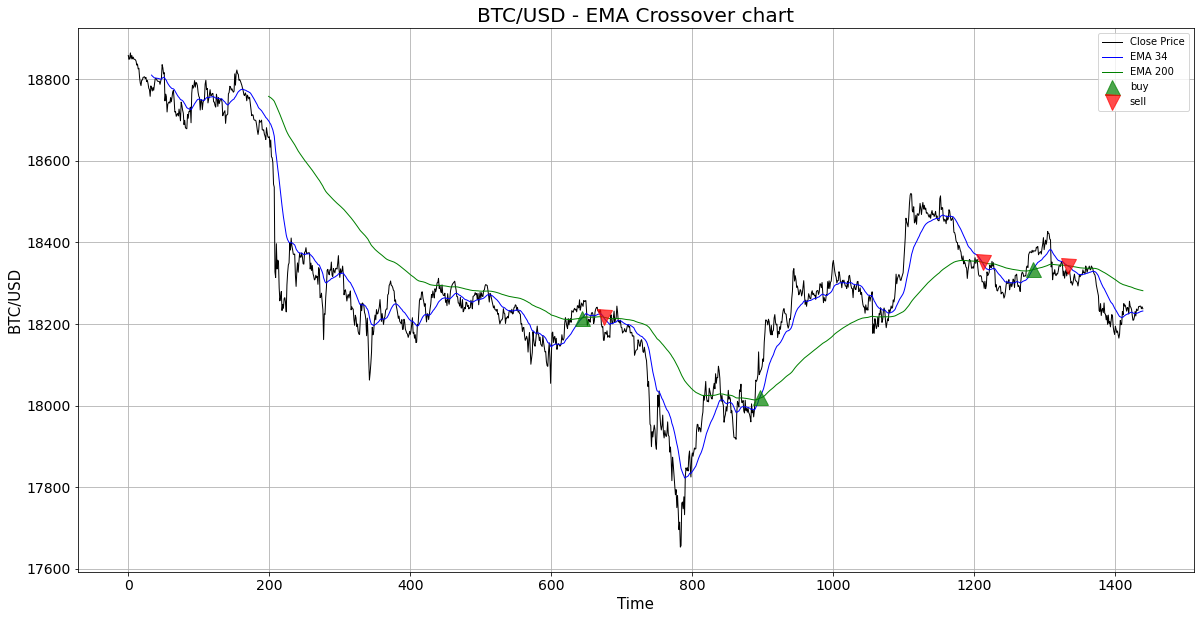

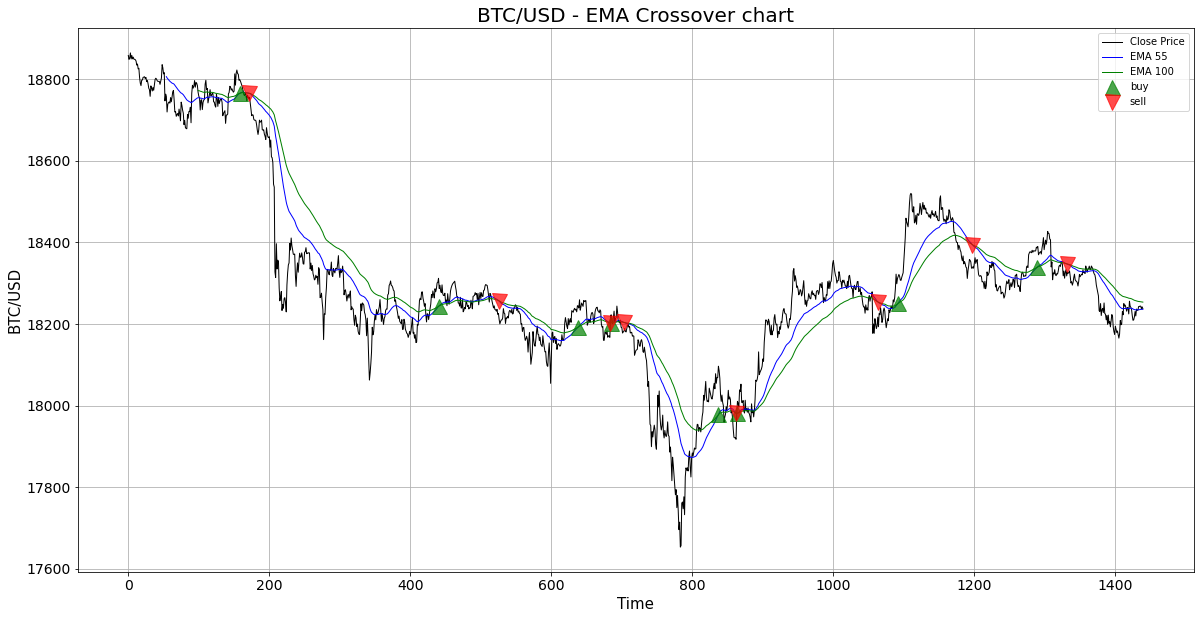

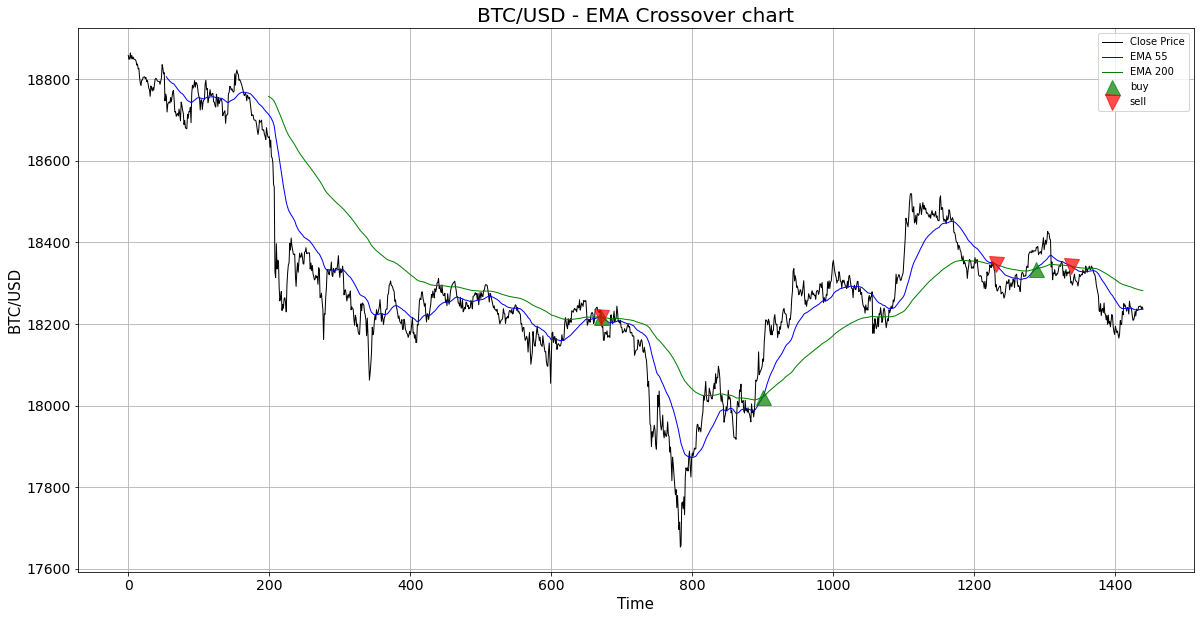

In [14]:
# Call this function to plot each EMA crossover strategies with Buy & Sell Signals
plot_crossover(data_real_min)

In [15]:
# Computes the current gauge of EMA Trading Signals based on minutely data
ema_strength = np.mean(ema_strategy(data_real_min))
ema_gauge = gauge(ema_strength)
print(ema_strength)
print(ema_gauge)

0.0
Neutral


In [16]:
# Computes the current gauge of Ichimoku Cloud Trading Signal based on minutely data
ichi_strategy = ichimoku_strategy(data_real_min)
ichi_strength = np.mean(ichi_strategy)
ichi_gauge = gauge(ichi_strength)
print(ichi_strength)
print(ichi_gauge)

0.5
Buy


## Current Overall Gauge of Trading Signals based on EMA & Ichimoku Cloud

In [17]:
# Make sure the function fill_trends(data) was called before running this cell
# Combines the result from 10 trading strategies based on EMA 
# and 2 trading strategies based on Ichimoku Cloud into a list
actions = np.append(ema_strategy(data_real_min), ichimoku_strategy(data_real_min)).tolist()

# Counts the number of strategies that signals sell, buy, and neutral
sell_num = countX(actions, x=-1)
buy_num = countX(actions, x=1)
neutral_num = countX(actions, x=0)
print('Sell: {} strategies'.format(sell_num)) 
print('Buy: {} strategies'.format(buy_num)) 
print('Neutral: {} strategies'.format(neutral_num)) 

# Computes the average trading signal and current gauge of the BTC/USD market
# based on 12 different trading strategies
overall_strength = np.mean(actions)
overall_gauge = gauge(overall_strength)
print('Current Strength: {}'.format(overall_strength))
print('Current Gauge: {}'.format(overall_gauge))

Sell: 0 strategies
Buy: 1 strategies
Neutral: 11 strategies
Current Strength: 0.08333333333333333
Current Gauge: Neutral


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/Tinghui/opt/anaconda3/lib/python3.8/site-packages/urllib3/connection.py", line 159, in _new_conn
    conn = connection.create_connection(
  File "/Users/Tinghui/opt/anaconda3/lib/python3.8/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Users/Tinghui/opt/anaconda3/lib/python3.8/socket.py", line 918, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/Tinghui/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "/Users/Tinghui/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpo